In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# Define a Goal
Our Goal is to create a Network Intrusion Detection System (NIDS).
Categorize each object that is a raw packet as:
- Attack or Not Attack (label 1 or 0)
- Category of the Attack.  

Using a **Supervised Classificator**, our model will be able to classify a packet captured in **Malicious** or not.

# Data AcQuisition (DAQ)
We used a non cleaned dataset found on kaggle.com: **UNSW-NB15**. The raw packet was created by the *'IXIA PerfectStorm tool'*. This dataset is a labeled datset and in particular has nine types of attacks: 
- Generic: Techniques used against all block-cypher.
- Fuzzers: Send random data to find vulnerabilities.
- Backdoors: Hidden access for unauthorized control.
- DoS: Overwhelm a system to disrupt service.
- Exploits: Use vulnerabilities for unauthorized access.
- Reconnaissance: Gather info to find vulnerabilities.
- Shellcode: Malicious code for system control.
- Worms: Self-spreading malware across networks.
- Analysis:  Gathering info for exploitation.

First we assign a column name according to *NUSW-NB15_features.csv*.

In [3]:
column_name = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur',
    'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service',
    'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb',
    'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
    'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
    'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
    'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
    'Label'
]
df = pd.read_csv('UNSW-NB15_4.csv', header=None, names=column_name)

# Data Exploration
The exploration of the data is made in order to identify the dataset content, to extract and visualize data. We will use this in order to indentify possible features in the dataset that we do not want.

In [4]:
df = df.drop_duplicates()
df.head(10)

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,...,,2,2,7,4,1,1,3,NaN,0
1,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,NaN,0
2,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,NaN,0
3,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,NaN,0
4,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,NaN,0
5,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,NaN,0
6,175.45.176.0,49582,149.171.126.12,80,tcp,FIN,0.189983,13304,268,254,...,,1,1,1,1,1,1,1,Exploits,1
7,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Fuzzers,1
8,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Exploits,1
11,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Backdoor,1


We make a describe() only for usefull feature:
- Dur: Analyzes the duration of connections.
- Sbytes, Dbytes: Amount of bytes exchanged between source and destination.
- Sload, Dload: Data transmission speed.
- Spkts, Dpkts: Number of packets sent and received.
- Sjit, Djit: Jitter of the connection (variation in delay).
- Sintpkt, Dintpkt: Interval between packets.
- Tcprtt, Synack, Ackdat: TCP round-trip time, SYN-ACK, and acknowledgment time.

In [5]:
column_described = [
    'dur', 'sbytes', 'dbytes', 'Sload', 'Dload', 'sloss', 'dloss',
    'Spkts', 'Dpkts', 'Sjit', 'Djit',
    'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat'
]

df[column_described].describe()


,dur,sbytes,dbytes,Sload,Dload,sloss,dloss,Spkts,Dpkts,Sjit,Djit,Sintpkt,Dintpkt,tcprtt,synack,ackdat
count,306719.000000,3.067190e+05,3.067190e+05,3.067190e+05,3.067190e+05,306719.000000,306719.000000,306719.000000,306719.000000,3.067190e+05,306719.000000,306719.000000,306719.000000,306719.000000,306719.000000,306719.000000
mean,0.667638,5.290531e+03,3.829690e+04,1.559210e+07,2.793255e+06,5.932414,17.427831,36.311018,46.010296,1.709003e+03,745.345346,155.636839,66.161261,0.012234,0.006456,0.005778
std,3.484700,7.808057e+04,1.629300e+05,9.581792e+07,4.430833e+06,30.319159,57.324461,85.554745,122.105238,1.472759e+04,2278.464267,2425.300693,1233.431546,0.080375,0.046563,0.041447
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001806,4.240000e+02,2.680000e+02,7.811491e+04,6.913363e+04,0.000000,0.000000,4.000000,4.000000,0.000000e+00,0.270590,0.254869,0.203000,0.000000,0.000000,0.000000
50%,0.023896,1.580000e+03,2.456000e+03,5.483568e+05,6.618999e+05,4.000000,4.000000,14.000000,18.000000,3.271329e+01,17.596372,0.776978,0.692854,0.000631,0.000502,0.000123
75%,0.346955,3.406000e+03,1.703000e+04,1.194410e+06,3.627428e+06,7.000000,15.000000,48.000000,44.000000,7.722584e+02,80.645797,12.723077,10.698917,0.000706,0.000562,0.000140
max,59.999989,1.106347e+07,1.283855e+07,5.600000e+09,2.290690e+07,4158.000000,4829.000000,8324.000000,9660.000000,1.201182e+06,120773.448400,84371.496000,52133.240000,10.037506,4.525272,5.512234


## Validating value 0 for the Duration of the packet
Value 0 in duration could be an error. let's compare it with other values relevant like *sbytes, dbytes, Sjit, Djit, sloss, or dloss*.

In [6]:
dur_zero = df[df['dur'] == 0]

In [7]:
columns_of_interest = ['sbytes', 'dbytes', 'Sjit', 'Djit', 'sloss', 'dloss']
dur_zero[columns_of_interest].describe()

,sbytes,dbytes,Sjit,Djit,sloss,dloss
count,389.000000,389.0,389.000000,389.0,389.0,389.0
mean,51.246787,0.0,4.065893,0.0,0.0,0.0
std,74.757552,0.0,6.188250,0.0,0.0,0.0
min,28.000000,0.0,0.000000,0.0,0.0,0.0
25%,46.000000,0.0,0.000000,0.0,0.0,0.0
50%,46.000000,0.0,0.000000,0.0,0.0,0.0
75%,46.000000,0.0,10.954515,0.0,0.0,0.0
max,1504.000000,0.0,15.492038,0.0,0.0,0.0


Instead it seems that everything is ok because every packet with *dur == 0* have a *sbytes* not zero and instead the *dbytes* are zero so no bytes are sent back to the source, this can due to a specific type of packet that do not need a response immmediately (UDP) or due to an error communication.
No packet loss is encountered so it is ok that the duration is zero because no retrasmission is needed. Jitter in the source *Sjit* with *mean* that low *4.0 ms* is ok, probably the max *15.5 ms* is an error because we are considering *dur* 0.   

We have seen that a low *jitter* is ok even if the duration is zero, this because the jitter is not related to a single packet but a record of packets that can have *dur* not equal to 0.

## Label Visualization
Explore if the dataset is balanced or not.

In [8]:
label_1_count = df['Label'].value_counts().get(1, 0)
print(f'Malicious packets: {label_1_count}')

Malicious packets: 25257


In [9]:
label_0_count = df['Label'].value_counts().get(0, 0)
print(f'Normal packets: {label_0_count}')

Normal packets: 281462


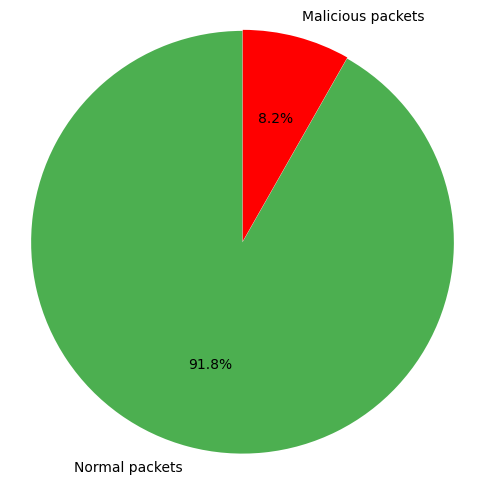

In [10]:
labels = ['Normal packets', 'Malicious packets']
sizes = [label_0_count, label_1_count]
colors = ['#4CAF50', '#FF0000']  

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.005, 0)) 
plt.axis('equal')
plt.show()

The dataset is **unbalanced**.

Now let's visualize the Attack Category one by one counting them.

In [11]:
attack_category_counts = df['attack_cat'].value_counts()
attack_category_counts.to_frame().T

attack_cat,Generic,Exploits,Fuzzers,Reconnaissance,DoS,Backdoor,Analysis,Shellcode,Worms
count,6894,6851,4970,3420,1465,623,621,371,42


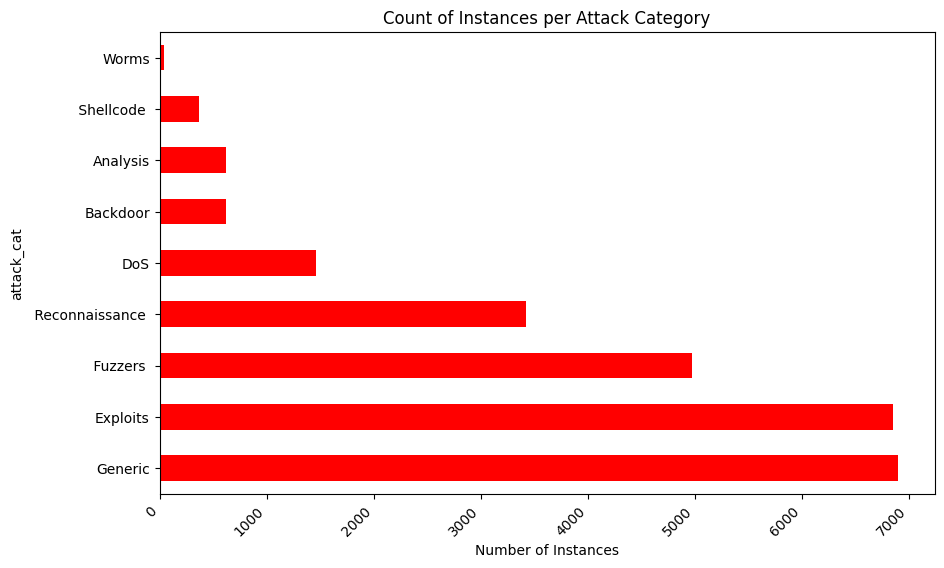

In [12]:
plt.figure(figsize=(10, 6))
attack_category_counts.plot(kind='barh', color='#FF0000')
plt.title('Count of Instances per Attack Category')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

In the dataset the *label* 0 indicating not an attack does not have a specific *attack category* feature. We need to add it in order to visualize clearly the distribuition of the *label*.

In [13]:
df.loc[df['Label'] == 0, 'attack_cat'] = 'Normal'

category_counts = df['attack_cat'].value_counts()
category_counts.to_frame().reset_index()

,attack_cat,count
0,Normal,281462
1,Generic,6894
2,Exploits,6851
3,Fuzzers,4970
4,Reconnaissance,3420
5,DoS,1465
6,Backdoor,623
7,Analysis,621
8,Shellcode,371
9,Worms,42


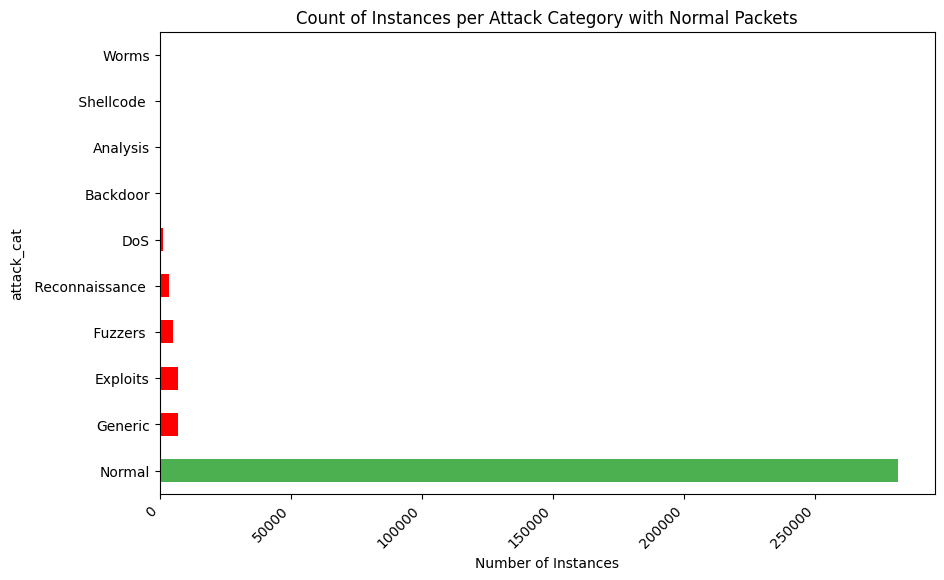

In [14]:
colors = ['#4CAF50' if category == 'Normal' else '#FF0000' for category in category_counts.index]

plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color=colors)
plt.title('Count of Instances per Attack Category with Normal Packets')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

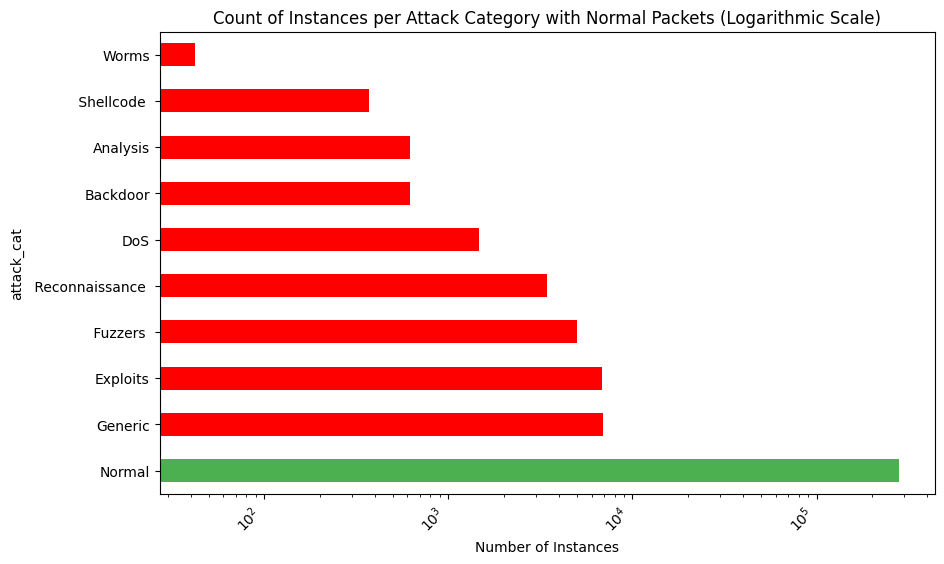

In [15]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', logx = True, color=colors)
plt.title('Count of Instances per Attack Category with Normal Packets (Logarithmic Scale)')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

Now our idea is map the *attack_cat* into 4 different category used commonly in intrusion detection:
- DoS: DoS, Worms
- U2R: Backdoor, Shellcode
- R2L: Exploits, Analysis
- Probe: Reconnaissance, Fuzzers, Generic
>[!NOTE]  
> *Worms* can be considered DoS attacks as they aim to duplicate and overcharge the network.  
> We classify *Generic* attacks under the Probe category, as they focus on information gathering and testing vulnerabilities (like *Brute Force Attack*).

In [16]:
df['attack_cat'] = df['attack_cat'].str.strip()

attack_categories = {
    'DoS': ['DoS', 'Worms'],
    'U2R': ['Backdoor', 'Shellcode'],
    'R2L': ['Exploits', 'Analysis'],
    'Probe': ['Reconnaissance', 'Fuzzers', 'Generic'],
    'Normal': ['Normal']
}

def assign_attack_group(attack_cat):
    for category, attacks in attack_categories.items():
        if attack_cat in attacks:
            return category
    return 'Unknown' 

df['attack_cat'] = df['attack_cat'].apply(assign_attack_group)


attack_group_count = df['attack_cat'].value_counts()
attack_group_count.to_frame().reset_index()




,attack_cat,count
0,Normal,281462
1,Probe,15284
2,R2L,7472
3,DoS,1507
4,U2R,994


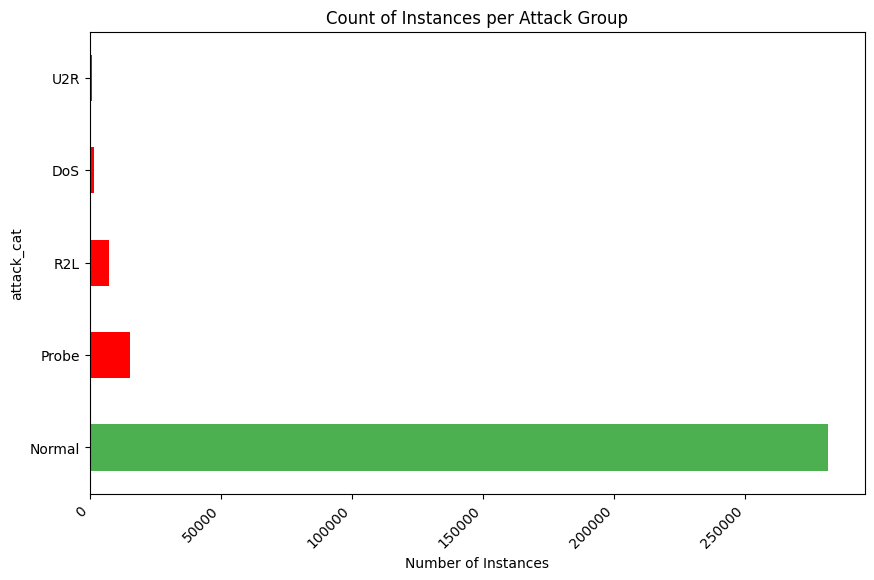

In [17]:
colors = ['#4CAF50', '#FF0000', '#FF0000', '#FF0000', '#FF0000']

plt.figure(figsize=(10, 6))
attack_group_count.plot(kind='barh' , color=colors)
plt.title('Count of Instances per Attack Group')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
df.head(10)

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,...,,2,2,7,4,1,1,3,Normal,0
1,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,Normal,0
2,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,Normal,0
3,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,Normal,0
4,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,Normal,0
5,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,Normal,0
6,175.45.176.0,49582,149.171.126.12,80,tcp,FIN,0.189983,13304,268,254,...,,1,1,1,1,1,1,1,R2L,1
7,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Probe,1
8,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,R2L,1
11,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,U2R,1


As we can see now the dataset contains 4 categories for *attacks* and 1 for *benign* packets.  
This could led to proceed in 2 different ways:
- Balance the dataset using SMOTE. Be carefull to make both *oversampling* for *malicious* category and *undersampling* for *benign* one. This because the dataset is very **unbalanced** and the traformation made by using only *oversampling* will probably *broke* the dataset, because passing from *25k* to *281k* is a **very strong trasformation**.
- Leave the dataset as it is and use *models* and *metrics* appropiated to an *unbalanced* dataset.

> [!NOTE]
> You shouldn't balanced the dataset as a whole, but only balance the training dataset and leave to test set as it is. Is important to don't make a prediction on a "crafted" test set.

## Nominal Feature

In [19]:
column_categoric=[
    'proto', 'state', 'service', 'attack_cat', 'Label'
    ]

df_filtered = df[df['Label'] == 1] 
df_filtered_count = (df_filtered[column_categoric].value_counts().to_frame().reset_index().rename(columns={0: 'count'}).head(15))
df_filtered_count

,proto,state,service,attack_cat,Label,count
0,udp,INT,dns,Probe,1,5443
1,tcp,FIN,-,Probe,1,3982
2,tcp,FIN,http,R2L,1,3020
3,udp,INT,-,Probe,1,2662
4,tcp,FIN,-,R2L,1,1253
5,tcp,FIN,http,Probe,1,1220
6,tcp,FIN,smtp,R2L,1,1033
7,unas,INT,-,Probe,1,630
8,tcp,FIN,http,DoS,1,471
9,unas,INT,-,R2L,1,420


All the *udp* attack are in *INT state* and for *dns* service.  
Most common *tcp* attack are *Exploits* and *Fuzzers* but in the *FIN* state. the *http* is the most attacked service. 

### Analysis of IP and PORT attributes
Check if there is some correlation between ip, port and attack to know if this two attributes are relevant for our analysis.<br>
Starting from IP:

In [20]:
attacks_df = df[df['Label'] == 1]

In [21]:
print(f"Total number of unique source IPs in attacks: {attacks_df['srcip'].nunique()}")
srcip_counts = attacks_df['srcip'].value_counts()
srcip_counts.head(45).to_frame().T

Total number of unique source IPs in attacks: 4


srcip,175.45.176.0,175.45.176.1,175.45.176.2,175.45.176.3
count,8290,6937,5537,4493


In [22]:
print(f"Total number of unique destination IPs in attacks: {attacks_df['dstip'].nunique()}")
dstip_counts = attacks_df['dstip'].value_counts()
dstip_counts.head(45).to_frame().T

Total number of unique destination IPs in attacks: 10


dstip,149.171.126.14,149.171.126.17,149.171.126.10,149.171.126.11,149.171.126.15,149.171.126.13,149.171.126.16,149.171.126.12,149.171.126.19,149.171.126.18
count,4650,4630,4195,2028,2022,1629,1611,1552,1517,1423


Now look at port:

In [23]:
print(f"Total number of unique source ports in attacks: {attacks_df['sport'].nunique()}")
sport_counts = attacks_df['sport'].value_counts()
sport_counts.head(45).to_frame().T

Total number of unique source ports in attacks: 13859


sport,0,47439,1043,68,137,19350,64679,38624,800,5060,...,59138,3982,5699,64492,26804,46455,44497,27072,49545,58351
count,3716,2717,2691,35,34,19,18,11,9,8,...,4,4,4,4,4,4,4,4,4,4


In [24]:
print(f"Total number of unique source ports in attacks: {attacks_df['dsport'].nunique()}")
sport_counts = attacks_df['dsport'].value_counts()
sport_counts.head(45).to_frame().T

Total number of unique source ports in attacks: 1026


dsport,53,80,0,111,25,179,445,520,21,514,...,3050,548,5900,500,88,8088,2000,50000,7144,2103
count,5542,4733,3716,2340,1270,1110,954,867,472,464,...,11,11,10,9,9,9,9,9,8,8


In the UNSW-NB15 dataset, the simulated attacks always originate from the same source IP addresses and are directed towards the same destination IP addresses, as described in the paper (https://ieeexplore.ieee.org/abstract/document/7348942). Therefore, the attributes srcip (Source IP address), dstip (Destination IP address), and sport (Source port number) have limited relevance for attack classification therefore in our case (lab data) will only create an **enormous** BIAS. These attributes do not reflect the variability of IP addresses and source ports observable in a real network environment, making them less informative.
<br>
On the other hand, the attribute dport (Destination port number) could be important but redundant, as there are other attributes like proto (protocol) and service that more or less carry the same information. <br>

### Analysis of Stime and Ltime attributes 
The attributes Stime and Ltime, which represent the start timestamps and the end one of network events, are likely of low relevance for classifying attacks. These timestamps are specific to the moment of recording and do not follow deterministic patterns useful for distinguishing between normal traffic and attacks. Additionally, the connection duration (dur) makes these attributes redundant. We will probably not consider them in our initial model but will study them more thoroughly during the feature selection phase using the correlation matrix to confirm their irrelevance.  

#### #TODO Analize Stime and Ltime in features selection using correlation matrix in feature selction phase

## Identify Missing and Erroneus Values 

In [25]:
missing_values = df.isnull().sum()
missing_values_filtered = missing_values[missing_values > 0]

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

print("Missing values in each column:")
missing_values_filtered.to_frame().T

Missing values in each column:


,ct_flw_http_mthd,is_ftp_login
0,273700,300350


The unique colums with missing value are *ct_flw_http_mthd* and *is_ftp_login*.

In [26]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
print("\nNumber of rows with at least one missing values in one column:", len(rows_with_missing_values))


Number of rows with at least one missing values in one column: 306719


In [27]:
total_rows = df.shape[0]
print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 306719


> [!Note]
> We have at least one missing value for row.

### ct_flw_http_mthd and *service* attributes analysis

Probably the *ct_flw_http_mthd* (number of flows that has methods such as Get and Post in http service) are directly linked with *service* attribute:

In [28]:
missing_values = df[df['ct_flw_http_mthd'].isnull()]

missing_values_by_service = missing_values['service'].value_counts()

print("Number of missing values in ct_flw_http_mthd column for each service:")
missing_values_by_service.to_frame().T

Number of missing values in ct_flw_http_mthd column for each service:


service,-,dns,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,18228,12140,6842,6692,363,30,26,25,9,7


if *ct_flw_http_mthd* is null no *http* in the column service is found. BUT

In [29]:
http_count = (df['service'] == 'http').sum()
other_count = total_rows - http_count

ct_flw_count = df['ct_flw_http_mthd'].notna().sum()

print(f"Number of rows without service 'http': {other_count}")
print(f"Number of rows with service 'http': {http_count}")
print(f"Number of rows with 'ct_flw_http_mthd': {ct_flw_count}")

Number of rows without service 'http': 273942
Number of rows with service 'http': 32777
Number of rows with 'ct_flw_http_mthd': 33019


The number of raws without service 'http' is not really the number of raws missing con the attribute *ct_flw_http_mthd*.  
Indeed the the number of raws not null of *ct_flw_http_mthd* is higher to the one with service *http* so some other service as *http* and this coul be an error in the dataset. The difference is **242**.

In [30]:
ct_flow_notna_values = df[df['ct_flw_http_mthd'].notna()]

ct_flow_notna_values_no_http = ct_flow_notna_values[ct_flow_notna_values['service'] != 'http']

service_counts = ct_flow_notna_values_no_http['service'].value_counts()

service_counts.to_frame().T

service,-
count,242


So there is an **error** and those service (-) should be **http**.

BEFORE

In [31]:
df['service'].value_counts().to_frame().T

service,-,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,168099,61481,32777,18228,12140,6842,6692,363,30,26,25,9,7


AFTER

In [32]:
df.loc[ct_flow_notna_values_no_http.index, 'service'] = 'http'

df['service'].value_counts().to_frame().T

service,-,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,6692,363,30,26,25,9,7


Now since the number of raws not null of the attribute *ct_flw_http_mthd* is equal to the packets with attribute *service* (33019) the attributes are correct.  
Regarding the other services, they cannot have HTTP methods.  

In [33]:
min_value = ct_flow_notna_values['ct_flw_http_mthd'].min()
max_value = ct_flow_notna_values['ct_flw_http_mthd'].max()

print(f"Numerical range for 'ct_flw_http_mthd': Min = {min_value}, Max = {max_value}")


Numerical range for 'ct_flw_http_mthd': Min = 1.0, Max = 9.0


Since the attribute *ct_flw_http_mthd* is a numerical value with those range, we can set the ct_flw_http_mthd value to 0 for rows where the service is one of these non-HTTP. This adjustment will be made during the preprocessing phase.

In [34]:
unspecified_service_rows = df[df['service'] == '-']
print(f"Number of rows with unspecified service: {len(unspecified_service_rows)}")

Number of rows with unspecified service: 167857


We can observe that there isn't missing value for the attribute *ct_flw_http_mthd* when the *service* is *http*.

As we can see the attribute *service* as values '-' and this because those values are Missing. 


Now check if service erroneus value are linked with the attacks to the network:

In [35]:
unspecified_service_rows = df[df['service'] == '-']
total_unspecified = len(unspecified_service_rows)

attack_rows = unspecified_service_rows[unspecified_service_rows['Label'] == 1]
total_attacks = len(attack_rows)

percentage_attack = (total_attacks / total_unspecified) * 100

print(f'Total Attacks with Unspecified Service: {total_attacks}')
print(f'Percentage of Attacks that have unspecified service:  {percentage_attack}')


Total Attacks with Unspecified Service: 12342
Percentage of Attacks that have unspecified service:  7.35268710866988


Since several instances representing attacks have the value '-' in the service column, it would not be advisable to remove those rows. Therefore, as mentioned above, we will substitute the value in pre-processing phase.

### is_ftp_login attribute analysis

Probably also the is_ftp_login (if the ftp session is accessed by user and password then 1 else 0) are directly linked with service attribute:

In [36]:
unspecified_is_ftp_login_rows = df[df['is_ftp_login'].isnull()]
print(f"Number of rows with unspecified is_ftp_login: {len(unspecified_is_ftp_login_rows)}")

Number of rows with unspecified is_ftp_login: 300350


In [37]:
missing_values = df[df['is_ftp_login'].isnull()]

missing_values_by_service = missing_values['service'].value_counts()

print("Number of missing values in is_ftp_login column for each service:")
missing_values_by_service.to_frame().T

Number of missing values in is_ftp_login column for each service:


service,-,dns,http,ftp-data,smtp,ssh,pop3,ftp,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,363,323,30,26,25,9,7


The value should be binary, but we have different integer values. Look at the numbers.

In [38]:
is_ftp_login_df = df['is_ftp_login'].value_counts()
is_ftp_login_df.to_frame().T

is_ftp_login,1.0,4.0,2.0
count,6335,27,7


In [39]:
non_missing_is_ftp_login_rows = df[df['is_ftp_login'].notnull()]
non_missing_is_ftp_login_rows_ftp = non_missing_is_ftp_login_rows[non_missing_is_ftp_login_rows['service'] == 'ftp']
service_count = non_missing_is_ftp_login_rows_ftp['service'].value_counts()
service_count.to_frame().T

service,ftp
count,6369


We can conclude that all non-missing values of is_ftp_login are within the ftp service. Therefore, during the preprocessing phase, we can substitute all positive values for this attribute with 1 and set the missing values to 0.  

The *is_ftp_login* attributes probably was only set to a value if it was present and was missing in all the other cases.

In [40]:
non_missing_is_ftp_login_null = df[df['is_ftp_login'].isnull()]

non_missing_is_ftp_login_rows_attack = non_missing_is_ftp_login_null[(non_missing_is_ftp_login_null['Label'] == 1) & (non_missing_is_ftp_login_null['service'] == 'ftp')]
service_count = non_missing_is_ftp_login_rows_attack['Label'].value_counts()

print("Number of attacks with missing is_ftp_login and service as ftp:")
service_count.to_frame().T

Number of attacks with missing is_ftp_login and service as ftp:


Label,1
count,171


Our first thought was to eliminate the column as it can say the same things for classifying an attack to *ftp*. But this is not true, indeed there are some missing values for *is_ftp_login* in the *ftp* service that belongs to the class label *1* (attack). So eliminating the column will only result in a loss of information.  
There are in *ftp* some attacks that does not depend on the fact that the user is accessed or not (*is_ftp_login*).

### ct_ftp_cmd attribute analysis
Numbers of flows that has a command in ftp session.

In [41]:
ct_ftp_cmd_df = df['ct_ftp_cmd'].value_counts()
ct_ftp_cmd_df.to_frame().T


ct_ftp_cmd,,1,4,2
count,300350,6335,27,7


In [42]:
non_empty_ct_ftp_cmd_rows = df[df['ct_ftp_cmd'] != ' ']
non_empty_ct_ftp_cmd_rows_ftp = non_empty_ct_ftp_cmd_rows[non_empty_ct_ftp_cmd_rows['service'] == 'ftp']
service_count = non_empty_ct_ftp_cmd_rows_ftp['service'].value_counts()
service_count.to_frame().T

service,ftp
count,6369


We observe that all rows with a 'ct_ftp_cmd' value different from null have 'ftp' as the 'service' attribute. Therefore, we can substitute the null values with 0. <br>

In [43]:
df['ct_ftp_cmd'].value_counts().to_frame().T

ct_ftp_cmd,,1,4,2
count,300350,6335,27,7


In [44]:
df['is_ftp_login'].value_counts().to_frame().T

is_ftp_login,1.0,4.0,2.0
count,6335,27,7


In [45]:
test = df
test['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').astype('Int64')

non_zero_rows = test[(test['is_ftp_login'].notna()) & (test['ct_ftp_cmd'] != ' ')]

are_values_equal = (non_zero_rows['is_ftp_login'] == non_zero_rows['ct_ftp_cmd']).all()

are_values_equal

np.True_

Indeed analysing those two attributes *is_ftp_login*, *ct_ftp_cmd* we notice that they are equals in number, in values and in raws.  
Probably one of them is wrong, even if not anyway the attributes together are redundant. So we decided to remove *is_ftp_login* that is probably the erroneous value beacause the documentation says that it should be a *Bynary* tipe.

#### #TODO Remove the columns *is_ftp_login* because is redundant.

Regarding all the consideration made for the attribute *is_ftp_login* they remain still valid because we can just apply that to the attribute *ct_ftp_cmd* indeed they are actually the same. 

## Overall overview of the values in the dataset

### Nominal Value

In [46]:
string_columns = df.select_dtypes(include=['object']).columns
print("Column with string values:")
string_columns.to_list()

Column with string values:


['srcip', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']

In [47]:
unique_values_count = df[string_columns].nunique()
print("\nNumber of unique values in each nominal column:")
unique_values_count.to_frame().T


Number of unique values in each nominal column:


,srcip,dstip,dsport,proto,state,service,attack_cat
0,38,43,48861,133,14,13,5


In [48]:
print("\nUnique values in each nominal column:")
for column in string_columns:
    unique_values = df[column].unique()
    print(f"\n{column}:")
    print(unique_values)


Unique values in each nominal column:

srcip:
['59.166.0.9' '59.166.0.2' '59.166.0.8' '59.166.0.0' '175.45.176.0'
 '175.45.176.1' '59.166.0.6' '59.166.0.1' '59.166.0.3' '59.166.0.5'
 '10.40.182.3' '10.40.170.2' '175.45.176.2' '59.166.0.4' '59.166.0.7'
 '175.45.176.3' '10.40.85.30' '10.40.182.1' '10.40.85.10' '10.40.85.1'
 '149.171.126.11' '149.171.126.12' '10.40.182.6' '149.171.126.14'
 '149.171.126.13' '149.171.126.8' '149.171.126.17' '149.171.126.18'
 '149.171.126.15' '149.171.126.19' '149.171.126.5' '149.171.126.6'
 '149.171.126.4' '149.171.126.1' '149.171.126.2' '149.171.126.0'
 '149.171.126.10' '149.171.126.7']

dstip:
['149.171.126.7' '149.171.126.2' '149.171.126.4' '149.171.126.8'
 '149.171.126.12' '149.171.126.11' '149.171.126.6' '149.171.126.0'
 '149.171.126.1' '149.171.126.5' '149.171.126.3' '149.171.126.9'
 '10.40.182.3' '10.40.170.2' '149.171.126.18' '149.171.126.13'
 '149.171.126.14' '149.171.126.10' '149.171.126.16' '149.171.126.19'
 '149.171.126.17' '149.171.126.15' '10

### Numerical values

In [49]:
numeric_columns = df.select_dtypes(include=['number']).columns
print("Columns with numeric values:")
print(numeric_columns.to_list())

Columns with numeric values:
['sport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label']


In [50]:
unique_values_count = df[numeric_columns].nunique()
print("\nNumber of unique values in each numerical column:")
unique_values_count.to_frame().T


Number of unique values in each numerical column:


,sport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
0,63728,142812,4572,3886,11,7,245,283,198260,198441,404,336,8,15,211584,211509,1230,1191,7,1386,213096,218471,11773,11771,184878,183900,22067,20917,19509,2,5,5,3,3,61,61,57,57,57,46,61,2


In [51]:
print("\nUnique values in each numerical column:")
for column in numeric_columns:
    unique_values = df[column].unique()
    print(f"\n{column}:")
    print(unique_values)


Unique values in each numerical column:

sport:
[ 7045  9685  1421 ... 48486 18826 45604]

dur:
[2.018860e-01 5.864748e+00 1.391000e-03 ... 2.200934e+00 5.649980e-01
 8.730600e-02]

sbytes:
[ 37552  19410    146 ... 269883   3498  14106]

dbytes:
[   3380 1087890     178 ...   60216  166054  772406]

sttl:
[ 31 254   0  62  63   1 255  60  64 252  29]

dttl:
[ 29 252   0  60 254  31  30]

sloss:
[  18    2    0   19   38    6    3    7   55   52   78    1   11    4
    9   30    8   21   31   13   17  999   54   53   24    5   10  102
   32   51  331   61  154   34  171   35   15  167   42   12   43  355
   22   28   77   94   50   16   29  186   20   23  149   33   48   65
   14   27   36   47  332   41  408  146  286   93  183   39 2688  619
   70 3129   87 3307   72  175 2401  125  120   73   76  130  131   44
  166   82  352  128  144  189  808   79   26 1111   25  747  271   49
 2623  932   37   40   90  279   45   68  552  280 2468   81  240   71
   56  177 3624 4158  238 3607  

# Data Pre-Processing

Already done:
- Delete duplicates. 
- Add value in *attack_cat* for Normal packets.
- Substitued the attribute *attack_cat* with new macro-categories.
- Resolved incongruence between attributes *ct_flw_http_mthd* and *service*.

## Data Cleaning

### Remove IP and Ports.

Delete attributes for source and destination *ip addresses* and *ports* (*srcip*, *dstip*, *sport*, *dsport*). 

In [52]:
df = df.drop(columns=['srcip', 'dstip', 'sport', 'dsport'])

df.head(5)

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1.459438e+06,1.307669e+05,52,42,255,255,1422136554,3572668484,722,80,0,0,456.043567,15.530109,1424250009,1424250009,3.943843,4.912488,0.000590,0.000473,0.000117,0,0,NaN,NaN,<NA>,2,2,7,4,1,1,3,Normal,0
1,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,NaN,<NA>,3,1,4,4,1,1,1,Normal,0
2,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,NaN,NaN,<NA>,3,5,2,7,1,1,4,Normal,0
3,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,NaN,NaN,<NA>,1,1,4,7,1,1,3,Normal,0
4,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,NaN,NaN,<NA>,2,5,2,1,1,1,2,Normal,0


### Missing values in attribute *service*

Substitute '-' with 'missing' in the attribute *service*

In [53]:
service_missing_value = df[df['service'] == '-']

df.loc[service_missing_value.index, 'service'] = 'missing'

df['service'].value_counts().to_frame().T

service,missing,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,6692,363,30,26,25,9,7


### Missing values in attribute *ct_flw_http_mthd*

Substitute missing values with *0.0* in the attribute *ct_flw_http_mthd*.

In [54]:
ct_flow_missing_value = df[df['ct_flw_http_mthd'].isnull()]

df.loc[ct_flow_missing_value.index, 'ct_flw_http_mthd'] = 0.0

df['ct_flw_http_mthd'].value_counts().to_frame().T

ct_flw_http_mthd,0.0,1.0,4.0,2.0,9.0,6.0
count,273700,32287,623,84,21,4


### Missing values in attribute *ct_ftp_cmd* 
As the documentations says this attribute should be *Integer* but it's a *string*. Firstly we will convert values in string and then fill the *Missing Values*

In [55]:
df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').astype('Int64')

ct_ftp_missing_value = df[df['ct_ftp_cmd'].isnull()]

df.loc[ct_ftp_missing_value.index, 'ct_ftp_cmd'] = 0.0

df['ct_ftp_cmd'].value_counts().to_frame().T

ct_ftp_cmd,0,1,4,2
count,300350,6335,27,7


### Remove *is_ftp_login* attribute

In [56]:
df = df.drop(columns=['is_ftp_login'])

df.head(5)

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1.459438e+06,1.307669e+05,52,42,255,255,1422136554,3572668484,722,80,0,0,456.043567,15.530109,1424250009,1424250009,3.943843,4.912488,0.000590,0.000473,0.000117,0,0,0.0,0,2,2,7,4,1,1,3,Normal,0
1,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,0,3,1,4,4,1,1,1,Normal,0
2,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,0.0,0,3,5,2,7,1,1,4,Normal,0
3,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,0.0,0,1,1,4,7,1,1,3,Normal,0
4,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,0.0,0,2,5,2,1,1,1,2,Normal,0


Drop duplicate again because we removed some columns.

In [57]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

## Data Preparation

Create the trainig test dataframe. We don't need Label because we are classifying with *attack_cat*

In [58]:
train_Y = df['attack_cat']
train_x_raw = df.drop(['attack_cat','Label'], axis=1)

Update colums lists.

In [59]:
string_columns = train_x_raw.select_dtypes(include=['object']).columns
numeric_columns = train_x_raw.select_dtypes(include=['number']).columns

string_columns.to_list()

['proto', 'state', 'service']

Use *pd.get_dummies* method because **SMOTE** and **Logistc Regression** Classifier cannot handle nominal columns.

In [60]:
train_x = pd.get_dummies(train_x_raw, columns=string_columns, drop_first=True)

dummy_variables = list(set(train_x)-set(train_x_raw))

print(dummy_variables)

['service_ftp-data', 'proto_netblt', 'proto_dgp', 'proto_swipe', 'state_URN', 'proto_iatp', 'proto_unas', 'proto_ospf', 'proto_isis', 'proto_micp', 'proto_tlsp', 'proto_cphb', 'proto_pim', 'proto_sat-mon', 'state_INT', 'proto_eigrp', 'proto_ip', 'proto_sdrp', 'proto_zero', 'proto_mtp', 'proto_ipv6-opts', 'proto_sun-nd', 'proto_ttp', 'proto_visa', 'proto_crudp', 'proto_st2', 'proto_pri-enc', 'proto_ipcomp', 'proto_xtp', 'service_radius', 'proto_pipe', 'proto_ptp', 'proto_igmp', 'proto_gmtp', 'proto_any', 'state_RST', 'proto_uti', 'state_ECR', 'proto_srp', 'proto_crtp', 'proto_l2tp', 'proto_etherip', 'proto_aris', 'proto_qnx', 'proto_mfe-nsp', 'proto_pvp', 'proto_rsvp', 'proto_ddp', 'proto_fc', 'proto_ipnip', 'service_ftp', 'proto_encap', 'proto_mux', 'proto_rvd', 'state_no', 'proto_xnet', 'state_TST', 'proto_nsfnet-igp', 'proto_dcn', 'proto_igp', 'proto_snp', 'proto_ipv6-route', 'proto_sctp', 'proto_ifmp', 'proto_icmp', 'proto_irtp', 'service_missing', 'proto_pup', 'proto_egp', 'proto_g

### Balancing the dataset

In [61]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [62]:
train_x = train_x.astype('float64')

train_x.head(15)

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_icmp,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rtp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,state_CON,state_ECO,state_ECR,state_FIN,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URN,state_no,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_missing,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.201886,37552.0,3380.0,31.0,29.0,18.0,8.0,1.459438e+06,1.307669e+05,52.0,42.0,255.0,255.0,1.422137e+09,3.572668e+09,722.0,80.0,0.0,0.0,456.043567,15.530109,1.424250e+09,1.424250e+09,3.943843,4.912488,0.000590,0.000473,0.000117,0.0,0.0,0.0,0.0,2.0,2.0,7.0,4.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5.864748,19410.0,1087890.0,31.0,29.0,2.0,370.0,2.640454e+04,1.481983e+06,364.0,746.0,255.0,255.0,3.896196e+08,3.946887e+08,53.0,1458.0,1.0,0.0,1031.366423,690.219581,1.424250e+09,1.424250e+09,16.155447,7.871279,0.000771,0.000638,0.000133,0.0,0.0,1.0,0.0,3.0,1.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001391,146.0,

In [63]:
train_x = train_x.astype('float64')

print('Labels with NO sampler:')
train_Y.value_counts().to_frame().T

Labels with NO sampler:


attack_cat,Normal,Probe,R2L,DoS,U2R
count,281128,14149,6971,1506,994


In [64]:
sampling_strategy = {"Normal":100000} 
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

train_x_under, train_Y_under = under_sampler.fit_resample(train_x, train_Y)

train_Y_under.value_counts().to_frame().T

attack_cat,Normal,Probe,R2L,DoS,U2R
count,100000,14149,6971,1506,994


In [65]:
smote = SMOTE(random_state=42)

train_x_balanced_100k, train_Y_balanced_100k = smote.fit_resample(train_x_under, train_Y_under)

train_Y_balanced_100k.value_counts().to_frame().T

attack_cat,DoS,Normal,Probe,R2L,U2R
count,100000,100000,100000,100000,100000


### Feature Selection

Using Decision tree to sort features for importance.

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


model = DecisionTreeClassifier(random_state=42)

model.fit(train_x_balanced_100k, train_Y_balanced_100k)

importances = pd.Series(model.feature_importances_, index=train_x_balanced_100k.columns)

selected_features = importances.sort_values(ascending=False).reset_index()
selected_features.columns = ['Feature', 'Importance']


selected_features_worst_10_dec = selected_features.tail(10)

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_x_balanced_100k)

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_scaled, train_Y_balanced_100k)

importances = pd.Series(np.abs(log_reg_model.coef_[0]), index=train_x_balanced_100k.columns)

selected_features = importances.sort_values(ascending=False).reset_index()
selected_features.columns = ['Feature', 'Importance']

selected_features_worst_10_reg = selected_features.tail(10)

/home/ankara/virtualEnv/aiEnv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
common_top_features = selected_features_worst_10_reg.merge(selected_features_worst_10_dec, on="Feature")

print(common_top_features)

# Data Processing

## Logistic Regression

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

### Unbalanced

Split the data into train and test:

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    train_x, train_Y, test_size=0.30, random_state=21)

Scale the data:

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create and train the logistic regression model and make prediction:

In [76]:
clf = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

KeyboardInterrupt: 

Evaluation metrics:

In [70]:
print("--------------------------")
print(f"Accuracy = {accuracy_score(y_pred, y_test)}")
print("--------------------------")
print("Classification Report:\n", classification_report(y_test, y_pred))

--------------------------
Accuracy = 0.9650861361771944
--------------------------
Classification Report:
               precision    recall  f1-score   support

         DoS       0.20      0.07      0.11       469
      Normal       0.99      0.99      0.99     84339
       Probe       0.69      0.78      0.73      4216
         R2L       0.68      0.67      0.68      2112
         U2R       0.10      0.04      0.06       289

    accuracy                           0.97     91425
   macro avg       0.53      0.51      0.51     91425
weighted avg       0.96      0.97      0.96     91425



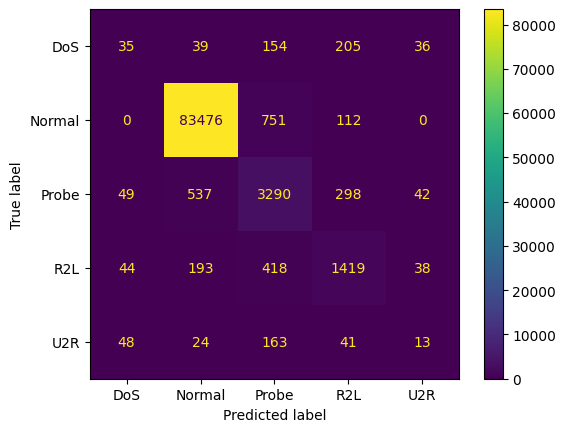

In [71]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)

Extracting Coefficients:

In [72]:
coefficients = clf.coef_[0]
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

coeff_df.T

,33,4,189,16,1,5,10,9,151,11,12,175,187,37,2,194,186,185,174,6,158,36,26,19,24,29,34,179,192,15,25,8,190,184,3,23,116,135,193,32,178,17,171,38,55,110,105,106,74,128,112,165,102,133,18,44,114,52,61,138,163,167,108,109,111,56,157,84,41,39,90,57,67,136,126,72,76,118,195,91,148,48,152,81,42,164,107,70,137,100,98,85,69,120,149,64,62,59,132,155,45,104,46,60,43,54,93,50,96,77,58,95,14,94,154,49,142,51,123,97,160,168,40,88,63,92,161,115,127,82,153,53,101,121,162,73,156,146,83,65,125,119,103,169,134,27,87,140,150,170,147,130,131,113,191,141,117,89,145,159,68,75,172,13,66,79,86,124,35,0,122,166,99,22,78,143,20,21,7,31,28,188,30,177,139,47,182,180,181,176,183,71,144,80,129,173
Feature,ct_srv_dst,dttl,service_missing,dmeansz,sbytes,sloss,Dpkts,Spkts,proto_tcp,swin,dwin,state_INT,service_http,ct_dst_sport_ltm,dbytes,service_ssh,service_ftp-data,service_ftp,state_FIN,dloss,proto_unas,ct_src_dport_ltm,synack,Sjit,Dintpkt,ct_state_ttl,ct_dst_ltm,state_RST,service_smtp,smeansz,tcprtt,Dload,service_pop3,service_dns,sttl,Sintpkt,proto_ospf,proto_sctp,service_snmp,ct_srv_src,state_REQ,trans_depth,state_CON,ct_dst_src_ltm,proto_crtp,proto_mtp,proto_merit-inp,proto_mfe-nsp,proto_ib,proto_rsvp,proto_narp,proto_wb-mon,proto_larp,proto_sccopmce,res_bdy_len,proto_arp,proto_nsfnet-igp,proto_compaq-peer,proto_egp,proto_sep,proto_vrrp,proto_xnet,proto_micp,proto_mobile,proto_mux,proto_crudp,proto_udp,proto_ipcomp,proto_any,proto_a/n,proto_ipv6,proto_dcn,proto_fire,proto_sdrp,proto_qnx,proto_i-nlsp,proto_idpr,proto_pim,service_ssl,proto_ipv6-frag,proto_sun-nd,proto_br-sat-mon,proto_tlsp,proto_igp,proto_argus,proto_wb-expak,proto_mhrp,proto_gre,proto_secure-vmtp,proto_kryptolan,proto_iso-ip,proto_ipcv,proto_gmtp,proto_pnni,proto_swipe,proto_encap,proto_eigrp,proto_ddx,proto_sat-mon,proto_trunk-2,proto_ax.25,proto_leaf-2,proto_bbn-rcc,proto_dgp,proto_aris,proto_cpnx,proto_ipv6-opts,proto_cftp,proto_irtp,proto_idpr-cmtp,proto_ddp,proto_ipx-n-ip,dtcpb,proto_ipv6-route,proto_trunk-1,proto_cbt,proto_snp,proto_chaos,proto_ptp,proto_isis,proto_vines,proto_xns-idp,proto_aes-sp3-d,proto_ipnip,proto_emcon,proto_ipv6-no,proto_visa,proto_nvp,proto_rdp,proto_il,proto_tp++,proto_cphb,proto_l2tp,proto_pri-enc,proto_vmtp,proto_iatp,proto_ttp,proto_st2,proto_ip,proto_etherip,proto_pvp,proto_pipe,proto_leaf-1,proto_xtp,proto_scps,ackdat,proto_iplt,proto_sm,proto_tcf,proto_zero,proto_stp,proto_rvd,proto_sat-expak,proto_netblt,service_radius,proto_smp,proto_pgm,proto_ippc,proto_srp,proto_uti,proto_ggp,proto_icmp,state_ECO,stcpb,proto_fc,proto_ifmp,proto_ipip,proto_pup,ct_src_ltm,dur,proto_prm,proto_wsn,proto_iso-tp4,Ltime,proto_idrp,proto_sprite-rpc,Djit,Stime,Sload,ct_ftp_cmd,is_sm_ips_ports,service_irc,ct_flw_http_mthd,state_PAR,proto_skip,proto_bna,state_URN,state_TST,state_TXD,state_MAS,state_no,proto_hmp,proto_sps,proto_igmp,proto_rtp,state_ECR
Coefficient,-1.998851,1.667587,-1.437222,1.274946,-1.254868,1.045545,0.83242,0.671094,-0.658078,-0.651095,-0.559332,0.553402,-0.550347,0.53068,-0.464438,-0.422403,-0.37317,-0.33468,-0.315145,-0.276175,0.248548,0.226829,-0.216357,0.215595,0.174423,0.166033,-0.14272,0.140351,0.135997,0.135995,-0.135727,-0.109925,0.108968,-0.096953,-0.094952,-0.089276,0.088402,0.076743,0.067802,-0.064321,0.06288,0.058935,0.056046,0.054829,0.046004,0.04496,0.044367,0.043999,0.038691,0.038508,0.03837,0.038085,0.037843,0.037698,0.037527,0.037277,0.037247,0.036517,0.036299,0.035747,0.035663,0.035442,0.035435,0.035384,0.035251,0.035165,-0.034996,0.034101,0.03392,0.031747,0.031526,0.031503,0.031284,0.031057,0.030514,0.030511,0.030488,0.030449,0.030278,0.030264,0.029943,0.029943,0.029876,0.029686,0.029426,0.029201,0.028876,0.028758,0.028756,0.028641,0.028384,0.028341,0.02831,0.028306,0.028198,0.028065,0.027949,0.027714,0.027678,0.027315,0.027283,0.027203,0.026805,0.026547,0.026416,0.026212,0.026172,0.026123,0.026033,0.026016,0.026003,0.025932,0.025784,0.025605,0.025521,0.025464,0.025404,0.025106,0.025087,0.025085,0.025077,0.024886,0.024827,0.024641,0.024613,

Accuracy: The model achieves an accuracy of 96.3%, but this metric is misleading due to class imbalance. The "Normal" class dominates, leading to high performance for this class but poor detection of attack classes.

Class Imbalance: The model performs exceptionally well on the "Normal" class but struggles with attack classes, especially DoS and U2R, showing very low recall and F1-scores for these categories (near zero for U2R).

Next Steps:

- Class Balancing: Addressing class imbalance through oversampling or undersampling of minority classes will improve performance on attack detection.
- Feature Selection: Not use all features but only top features based on large absolute coefficients

Now use the balanced dataframe:
- train_Y_balanced_15k
- train_Y_balanced_100k

### Training test Balanced with 100k for all categories (*train_Y_balanced_100k*)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    train_x_balanced_100k, train_Y_balanced_100k, test_size=0.30, random_state=21)

Scale the data:

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create and train the logistic regression model and make prediction:

In [75]:
clf = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

In [76]:
print("--------------------------")
print(f"Accuracy = {accuracy_score(y_pred, y_test)}")
print("--------------------------")
print("Classification Report:\n", classification_report(y_test, y_pred))

--------------------------
Accuracy = 0.7015533333333334
--------------------------
Classification Report:
               precision    recall  f1-score   support

         DoS       0.51      0.25      0.33     29913
      Normal       1.00      0.97      0.99     29949
       Probe       0.78      0.71      0.74     29826
         R2L       0.65      0.69      0.67     30102
         U2R       0.57      0.88      0.69     30210

    accuracy                           0.70    150000
   macro avg       0.70      0.70      0.68    150000
weighted avg       0.70      0.70      0.68    150000



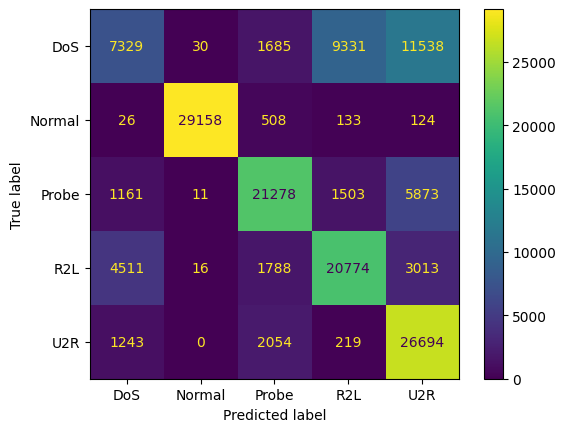

In [77]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)

In [78]:
coefficients = clf.coef_[0]
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

coeff_df.T

,4,1,5,10,8,189,36,175,33,192,9,187,174,151,11,37,6,194,186,190,2,12,29,157,18,158,184,191,178,31,185,17,193,24,16,188,135,179,3,195,26,111,49,15,32,41,42,61,146,90,20,171,109,81,25,167,19,58,115,46,51,70,148,138,67,83,149,92,63,124,156,168,142,128,143,154,77,34,118,93,39,40,136,169,97,94,48,86,139,104,57,108,155,62,106,163,76,91,78,164,126,132,65,102,153,110,159,127,84,122,68,101,69,162,74,152,55,105,60,73,112,71,95,100,140,145,134,107,45,123,89,38,113,141,59,88,125,53,13,43,130,121,103,50,44,165,98,54,82,87,133,0,64,131,147,79,114,137,166,96,47,161,72,52,85,99,150,56,120,117,160,144,28,66,170,35,119,14,22,75,27,172,116,80,30,23,182,183,177,21,7,129,176,173,181,180
Feature,dttl,sbytes,sloss,Dpkts,Dload,service_missing,ct_src_dport_ltm,state_INT,ct_srv_dst,service_smtp,Spkts,service_http,state_FIN,proto_tcp,swin,ct_dst_sport_ltm,dloss,service_ssh,service_ftp-data,service_pop3,dbytes,dwin,ct_state_ttl,proto_udp,res_bdy_len,proto_unas,service_dns,service_radius,state_REQ,ct_ftp_cmd,service_ftp,trans_depth,service_snmp,Dintpkt,dmeansz,service_irc,proto_sctp,state_RST,sttl,service_ssl,synack,proto_mux,proto_cbt,smeansz,ct_srv_src,proto_any,proto_argus,proto_egp,proto_st2,proto_ipv6,Djit,state_CON,proto_mobile,proto_igp,tcprtt,proto_xnet,Sjit,proto_ddp,proto_nvp,proto_bbn-rcc,proto_chaos,proto_gre,proto_sun-nd,proto_sep,proto_fire,proto_ip,proto_swipe,proto_ipv6-no,proto_emcon,proto_pup,proto_ttp,proto_xns-idp,proto_snp,proto_rsvp,proto_sprite-rpc,proto_trunk-1,proto_idpr-cmtp,ct_dst_ltm,proto_pim,proto_ipv6-opts,proto_a/n,proto_aes-sp3-d,proto_sdrp,proto_xtp,proto_isis,proto_ipv6-route,proto_br-sat-mon,proto_ipip,proto_skip,proto_leaf-2,proto_dcn,proto_micp,proto_trunk-2,proto_eigrp,proto_mfe-nsp,proto_vrrp,proto_idpr,proto_ipv6-frag,proto_idrp,proto_wb-expak,proto_qnx,proto_sat-mon,proto_etherip,proto_larp,proto_tp++,proto_mtp,proto_uti,proto_rdp,proto_ipcomp,proto_prm,proto_ggp,proto_l2tp,proto_gmtp,proto_vmtp,proto_ib,proto_tlsp,proto_crtp,proto_merit-inp,proto_dgp,proto_iatp,proto_narp,proto_hmp,proto_ipx-n-ip,proto_kryptolan,proto_sm,proto_srp,proto_scps,proto_mhrp,proto_ax.25,proto_ptp,proto_ippc,ct_dst_src_ltm,proto_netblt,proto_smp,proto_ddx,proto_ipnip,proto_pvp,proto_cphb,stcpb,proto_aris,proto_rvd,proto_pri-enc,proto_leaf-1,proto_cftp,proto_arp,proto_wb-mon,proto_iso-ip,proto_cpnx,proto_il,proto_iplt,proto_sccopmce,dur,proto_encap,proto_sat-expak,proto_stp,proto_ifmp,proto_nsfnet-igp,proto_secure-vmtp,proto_wsn,proto_irtp,proto_bna,proto_visa,proto_i-nlsp,proto_compaq-peer,proto_ipcv,proto_iso-tp4,proto_tcf,proto_crudp,proto_pnni,proto_pgm,proto_vines,proto_sps,is_sm_ips_ports,proto_fc,proto_zero,ct_src_ltm,proto_pipe,dtcpb,Ltime,proto_icmp,ackdat,state_ECO,proto_ospf,proto_igmp,ct_flw_http_mthd,Sintpkt,state_URN,state_no,state_PAR,Stime,Sload,proto_rtp,state_MAS,state_ECR,state_TXD,state_TST
Coefficient,7.113889,-5.302264,5.159903,4.536128,-3.565905,-2.926738,2.887718,2.31249,-2.226881,2.015369,1.906184,-1.878227,-1.869452,-1.796013,-1.795864,-1.756645,-1.346058,-1.280991,1.273654,1.256451,-1.098329,-1.08862,-0.968106,-0.922819,0.769058,0.76178,0.737917,-0.714058,0.662971,0.654077,-0.641763,0.63464,0.531854,-0.500183,0.497169,0.385724,0.374255,0.36549,-0.360756,0.314242,-0.284415,0.225688,0.221036,0.197293,-0.178025,0.164312,0.157195,0.154184,0.151305,0.150254,0.149151,-0.14667,0.144891,0.141977,-0.139921,0.137596,-0.130826,0.13067,0.129524,0.126426,0.118425,0.118185,0.114151,0.112307,0.107872,0.105877,0.105747,0.105685,0.104584,0.104426,0.102895,0.101553,0.097089,0.096741,0.095337,0.094034,0.092547,-0.091966,0.091395,0.091332,0.090561,0.090425,0.090053,0.088622,0.088561,0.08786,0.087122,0.086834,0.086576,0.086255,0.08604,0.085567,0.085053,0.08491,0.084746,0.084217,0.084092,0.083886,0.082536,0.082529,0.082291,0.081709,0.081339,0.080912,0.080564,0.080314,0.080294,0.080078,0.079655,0.07955,0.079521,0.079409,0.079184,0.079134,0.078186,0.076407,0.076367,0.075421,0.075401,0.075333,0.074876,0.074443,0.074429,0.074304,0.07423

### Balanced Dataset and CrossValidation

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns

Use cross validation with 10 splits.

In [80]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Define the model.

In [81]:
clf = LogisticRegression(max_iter=1000, random_state=42)
fold_results = []

Use cross validation with undersampling and SMOTE for training the model.


--- Fold 1/10 ---
              precision    recall  f1-score       support
DoS            0.106529  0.206667  0.140590    150.000000
Normal         0.999745  0.974496  0.986959  28113.000000
Probe          0.661745  0.696820  0.678830   1415.000000
R2L            0.642968  0.596844  0.619048    697.000000
U2R            0.096273  0.620000  0.166667    100.000000
accuracy       0.948023  0.948023  0.948023      0.948023
macro avg      0.501452  0.618965  0.518418  30475.000000
weighted avg   0.968530  0.948023  0.957380  30475.000000


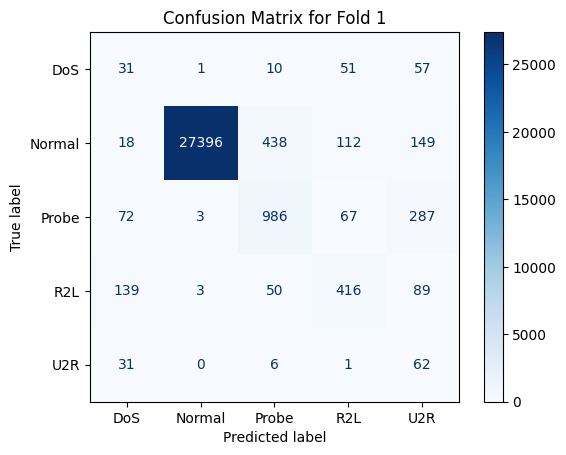


--- Fold 2/10 ---
              precision    recall  f1-score       support
DoS            0.096899  0.166667  0.122549    150.000000
Normal         1.000000  0.975100  0.987393  28113.000000
Probe          0.641992  0.674205  0.657704   1415.000000
R2L            0.647951  0.612626  0.629794    697.000000
U2R            0.110774  0.730000  0.192358    100.000000
accuracy       0.948056  0.948056  0.948056      0.948056
macro avg      0.499523  0.631720  0.517960  30475.000000
weighted avg   0.967962  0.948056  0.957041  30475.000000


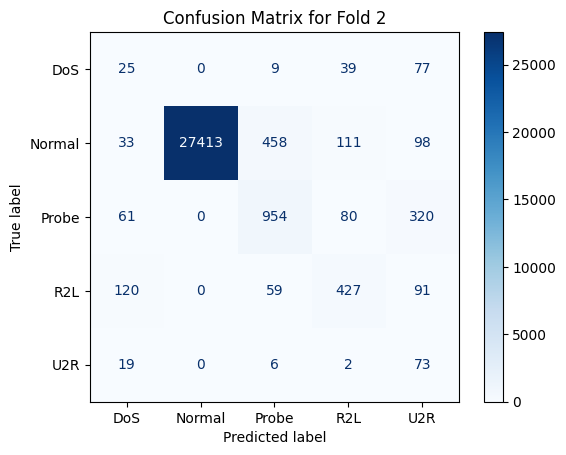


--- Fold 3/10 ---
              precision    recall  f1-score       support
DoS            0.119718  0.225166  0.156322    151.000000
Normal         0.999890  0.973856  0.986701  28113.000000
Probe          0.624005  0.665018  0.643859   1415.000000
R2L            0.660091  0.624103  0.641593    697.000000
U2R            0.110420  0.717172  0.191375     99.000000
accuracy       0.946973  0.946973  0.946973      0.946973
macro avg      0.502825  0.641063  0.523970  30475.000000
weighted avg   0.967415  0.946973  0.956191  30475.000000


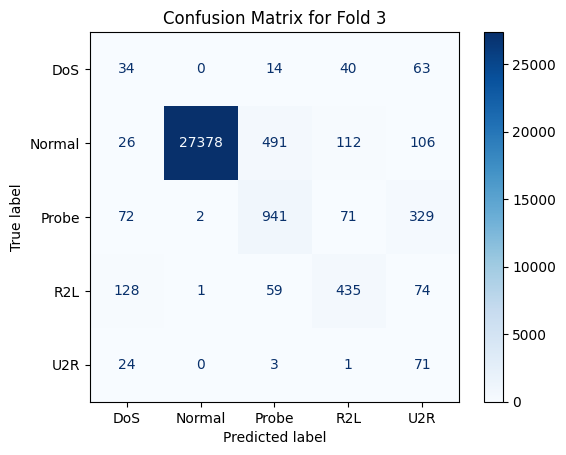


--- Fold 4/10 ---
              precision    recall  f1-score       support
DoS            0.100649  0.205298  0.135076    151.000000
Normal         0.999891  0.974709  0.987139  28113.000000
Probe          0.634386  0.638869  0.636620   1415.000000
R2L            0.627093  0.591105  0.608567    697.000000
U2R            0.108824  0.747475  0.189987     99.000000
accuracy       0.945792  0.945792  0.945792      0.945792
macro avg      0.494168  0.631491  0.511478  30475.000000
weighted avg   0.967043  0.945792  0.955394  30475.000000


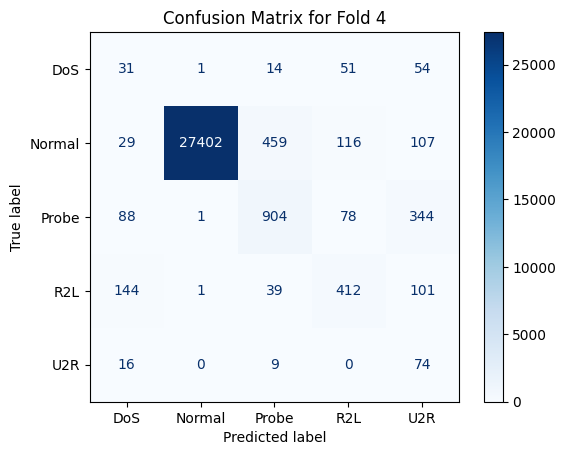


--- Fold 5/10 ---
              precision    recall  f1-score       support
DoS            0.105263  0.198675  0.137615    151.000000
Normal         0.999927  0.975136  0.987376  28113.000000
Probe          0.655870  0.686926  0.671039   1415.000000
R2L            0.634921  0.573888  0.602864    697.000000
U2R            0.107251  0.717172  0.186597     99.000000
accuracy       0.947892  0.947892  0.947892      0.947892
macro avg      0.500646  0.630359  0.517098  30475.000000
weighted avg   0.968271  0.947892  0.957082  30475.000000


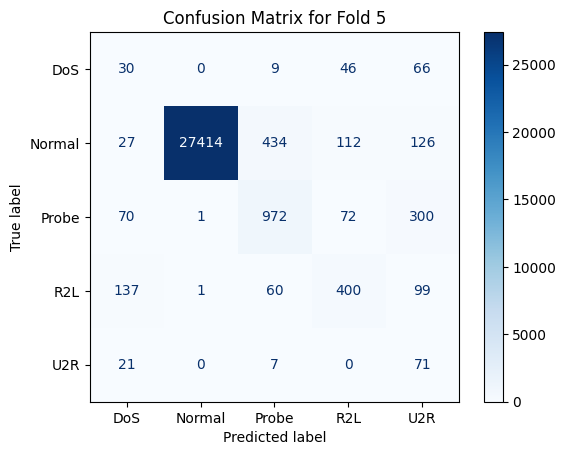


--- Fold 6/10 ---
              precision    recall  f1-score       support
DoS            0.090909  0.178808  0.120536    151.000000
Normal         0.999891  0.974709  0.987139  28113.000000
Probe          0.640442  0.655830  0.648045   1415.000000
R2L            0.665109  0.612626  0.637789    697.000000
U2R            0.090909  0.626263  0.158771     99.000000
accuracy       0.946546  0.946546  0.946546      0.946546
macro avg      0.497452  0.609647  0.510456  30475.000000
weighted avg   0.968087  0.946546  0.956420  30475.000000


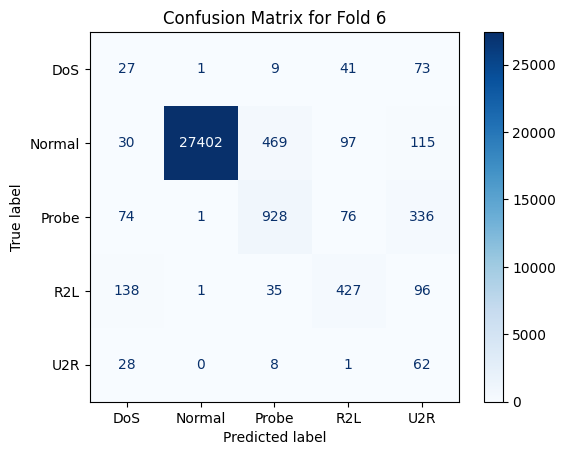


--- Fold 7/10 ---
              precision    recall  f1-score      support
DoS            0.108280  0.225166  0.146237    151.00000
Normal         0.999854  0.973358  0.986428  28113.00000
Probe          0.624501  0.662898  0.643126   1415.00000
R2L            0.636218  0.569584  0.601060    697.00000
U2R            0.091454  0.616162  0.159269     99.00000
accuracy       0.944840  0.944840  0.944840      0.94484
macro avg      0.492061  0.609433  0.507224  30475.00000
weighted avg   0.966740  0.944840  0.954824  30475.00000


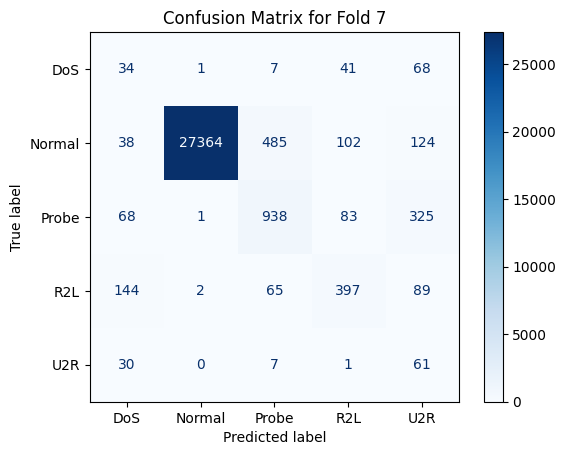


--- Fold 8/10 ---
              precision    recall  f1-score       support
DoS            0.104027  0.205298  0.138085    151.000000
Normal         0.999854  0.975243  0.987395  28113.000000
Probe          0.655647  0.672792  0.664109   1415.000000
R2L            0.646417  0.595409  0.619866    697.000000
U2R            0.095166  0.636364  0.165572     99.000000
accuracy       0.947596  0.947596  0.947596      0.947596
macro avg      0.500222  0.617021  0.515005  30475.000000
weighted avg   0.968411  0.947596  0.957101  30475.000000


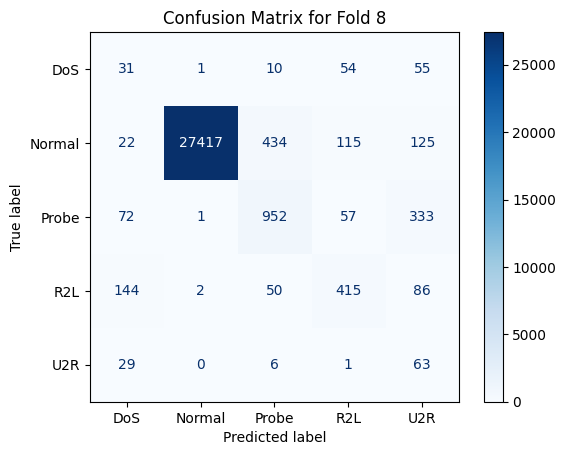


--- Fold 9/10 ---
              precision    recall  f1-score       support
DoS            0.123288  0.240000  0.162896    150.000000
Normal         0.999891  0.975740  0.987668  28112.000000
Probe          0.640273  0.663366  0.651615   1414.000000
R2L            0.634703  0.597421  0.615498    698.000000
U2R            0.102073  0.640000  0.176066    100.000000
accuracy       0.947857  0.947857  0.947857      0.947857
macro avg      0.500046  0.623305  0.518749  30474.000000
weighted avg   0.967579  0.947857  0.956827  30474.000000


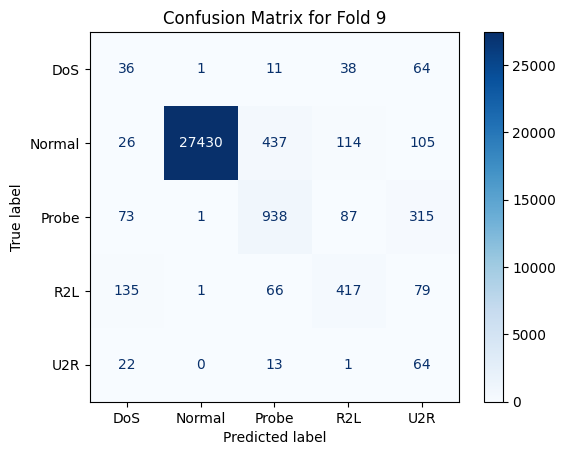


--- Fold 10/10 ---
              precision    recall  f1-score       support
DoS            0.117450  0.233333  0.156250    150.000000
Normal         0.999927  0.973214  0.986390  28112.000000
Probe          0.628061  0.670671  0.648667   1415.000000
R2L            0.653968  0.591105  0.620950    697.000000
U2R            0.100890  0.680000  0.175711    100.000000
accuracy       0.945823  0.945823  0.945823      0.945823
macro avg      0.500059  0.629665  0.517593  30474.000000
weighted avg   0.967453  0.945823  0.955604  30474.000000


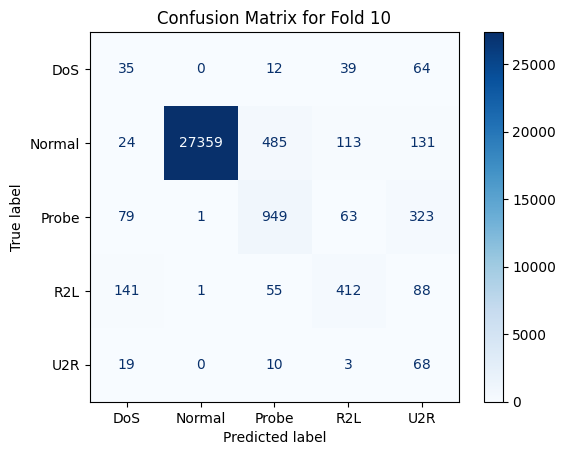

In [82]:
for fold, (train_idx, test_idx) in enumerate(skf.split(train_x, train_Y)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    X_train_raw, X_test_raw = train_x.iloc[train_idx], train_x.iloc[test_idx]
    y_train, y_test = train_Y.iloc[train_idx], train_Y.iloc[test_idx]
    
    # Undersample only the training set
    sampling_strategy = {"Normal": 100000}
    under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_under, y_train_under = under_sampler.fit_resample(X_train_raw, y_train)
    
    # SMOTE the other parts
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test_raw)
    
    clf.fit(X_train_scaled, y_train_balanced)
    
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    fold_results.append({
        'Fold': fold + 1,
        'Accuracy': acc,
        'Precision (weighted)': report['weighted avg']['precision'],
        'Recall (weighted)': report['weighted avg']['recall'],
        'F1-Score (weighted)': report['weighted avg']['f1-score'],
        'Confusion Matrix': cm
    })

    print(pd.DataFrame(report).T)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()

In [83]:
results_df = pd.DataFrame(fold_results)
print("\n--- Summary of Results ---")
print(results_df[['Fold', 'Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']])


--- Summary of Results ---
   Fold  Accuracy  Precision (weighted)  Recall (weighted)  \
0     1  0.948023              0.968530           0.948023   
1     2  0.948056              0.967962           0.948056   
2     3  0.946973              0.967415           0.946973   
3     4  0.945792              0.967043           0.945792   
4     5  0.947892              0.968271           0.947892   
5     6  0.946546              0.968087           0.946546   
6     7  0.944840              0.966740           0.944840   
7     8  0.947596              0.968411           0.947596   
8     9  0.947857              0.967579           0.947857   
9    10  0.945823              0.967453           0.945823   

   F1-Score (weighted)  
0             0.957380  
1             0.957041  
2             0.956191  
3             0.955394  
4             0.957082  
5             0.956420  
6             0.954824  
7             0.957101  
8             0.956827  
9             0.955604  


In [84]:
summary_stats = results_df[['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']].agg(['mean', 'std'])
print("\n--- Overall Performance ---")
print(summary_stats)


--- Overall Performance ---
      Accuracy  Precision (weighted)  Recall (weighted)  F1-Score (weighted)
mean  0.946940              0.967749           0.946940             0.956386
std   0.001142              0.000599           0.001142             0.000862


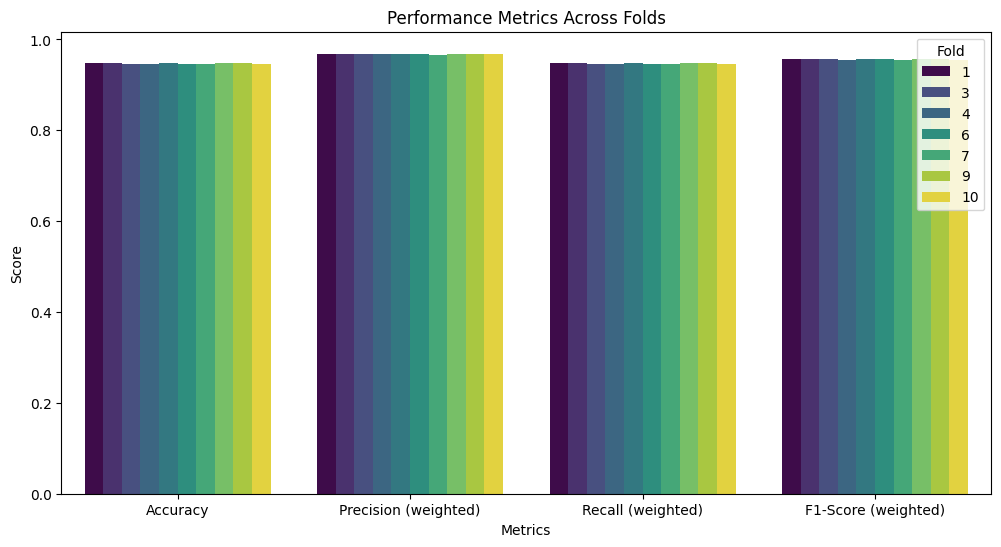

In [85]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars=['Fold'], 
                                 value_vars=['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']), 
            x='variable', y='value', hue='Fold', palette='viridis')
plt.title("Performance Metrics Across Folds")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title="Fold", loc="upper right")
plt.show()

## Random Forest
Number of Decision tree = 50 and using Cross Validation.

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [102]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)


--- Fold 1/10 ---
              precision    recall  f1-score       support
DoS            0.200000  0.173333  0.185714    150.000000
Normal         0.998809  0.984100  0.991400  28113.000000
Probe          0.726801  0.891166  0.800635   1415.000000
R2L            0.722295  0.794835  0.756831    697.000000
U2R            0.215278  0.310000  0.254098    100.000000
accuracy       0.969253  0.969253  0.969253      0.969253
macro avg      0.572636  0.630687  0.597736  30475.000000
weighted avg   0.973352  0.969253  0.970792  30475.000000


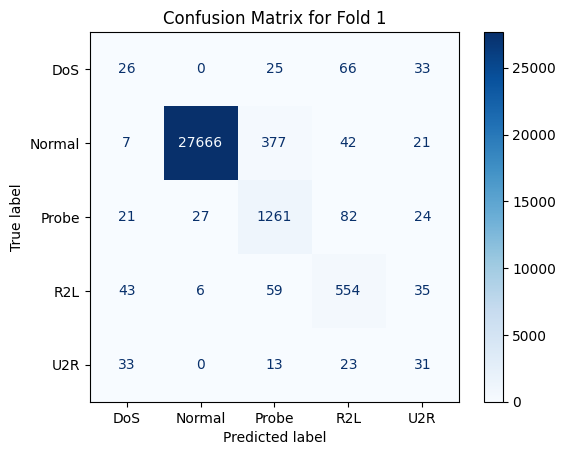


--- Fold 2/10 ---
              precision    recall  f1-score       support
DoS            0.179104  0.160000  0.169014    150.000000
Normal         0.998737  0.984847  0.991744  28113.000000
Probe          0.733961  0.881272  0.800899   1415.000000
R2L            0.712383  0.767575  0.738950    697.000000
U2R            0.183432  0.310000  0.230483    100.000000
accuracy       0.968794  0.968794  0.968794      0.968794
macro avg      0.561524  0.620739  0.586218  30475.000000
weighted avg   0.973185  0.968794  0.970553  30475.000000


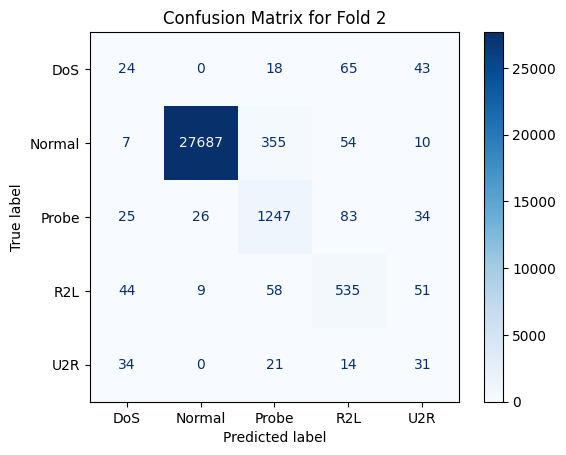


--- Fold 3/10 ---
              precision    recall  f1-score       support
DoS            0.225806  0.185430  0.203636    151.000000
Normal         0.998772  0.983282  0.990966  28113.000000
Probe          0.705916  0.868551  0.778834   1415.000000
R2L            0.724490  0.814921  0.767049    697.000000
U2R            0.214765  0.323232  0.258065     99.000000
accuracy       0.968007  0.968007  0.968007      0.968007
macro avg      0.573950  0.635083  0.599710  30475.000000
weighted avg   0.972524  0.968007  0.969713  30475.000000


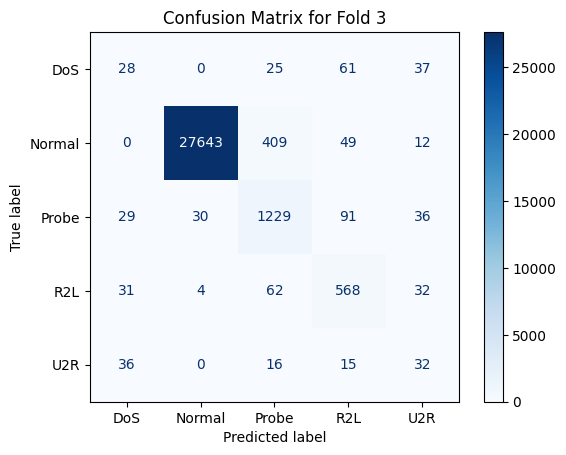


--- Fold 4/10 ---
              precision    recall  f1-score       support
DoS            0.206107  0.178808  0.191489    151.000000
Normal         0.998593  0.984278  0.991383  28113.000000
Probe          0.724036  0.862191  0.787097   1415.000000
R2L            0.697943  0.779053  0.736271    697.000000
U2R            0.239766  0.414141  0.303704     99.000000
accuracy       0.968072  0.968072  0.968072      0.968072
macro avg      0.573289  0.643694  0.601989  30475.000000
weighted avg   0.972576  0.968072  0.969866  30475.000000


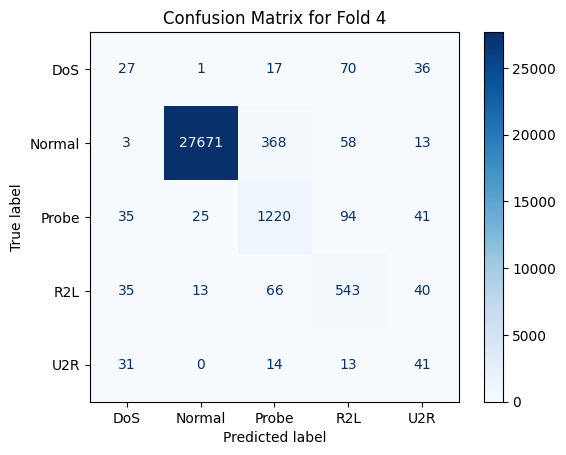


--- Fold 5/10 ---
              precision    recall  f1-score       support
DoS            0.155039  0.132450  0.142857    151.000000
Normal         0.998881  0.984384  0.991580  28113.000000
Probe          0.726531  0.880565  0.796166   1415.000000
R2L            0.712583  0.771879  0.741047    697.000000
U2R            0.216374  0.373737  0.274074     99.000000
accuracy       0.968499  0.968499  0.968499      0.968499
macro avg      0.561881  0.628603  0.589145  30475.000000
weighted avg   0.972964  0.968499  0.970240  30475.000000


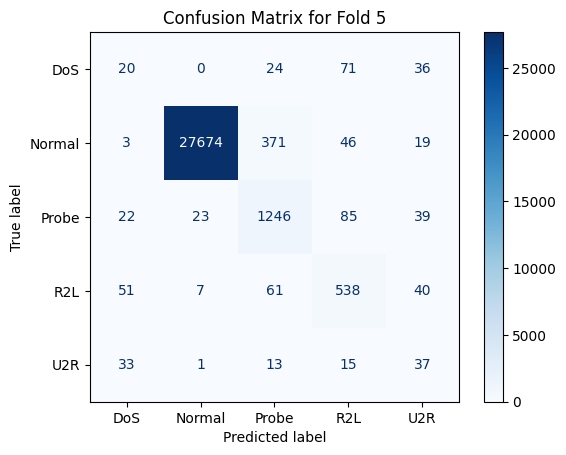


--- Fold 6/10 ---
              precision    recall  f1-score      support
DoS            0.181818  0.158940  0.169611    151.00000
Normal         0.999097  0.983993  0.991488  28113.00000
Probe          0.728446  0.877739  0.796154   1415.00000
R2L            0.704244  0.761836  0.731909    697.00000
U2R            0.173469  0.343434  0.230508     99.00000
accuracy       0.967810  0.967810  0.967810      0.96781
macro avg      0.557415  0.625189  0.583934  30475.00000
weighted avg   0.973055  0.967810  0.969937  30475.00000


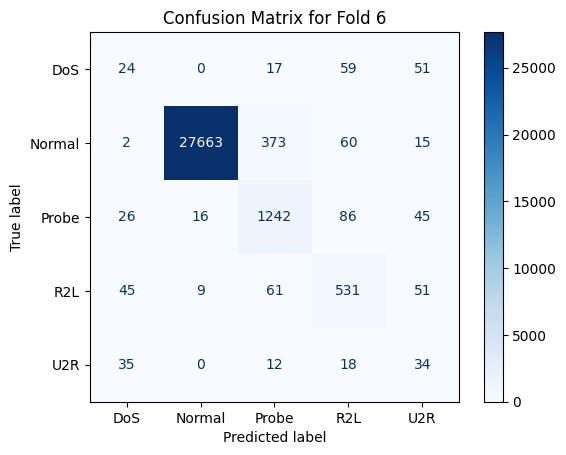


--- Fold 7/10 ---
              precision    recall  f1-score       support
DoS            0.168000  0.139073  0.152174    151.000000
Normal         0.998520  0.983637  0.991023  28113.000000
Probe          0.713620  0.866431  0.782636   1415.000000
R2L            0.724093  0.802009  0.761062    697.000000
U2R            0.150602  0.252525  0.188679     99.000000
accuracy       0.967482  0.967482  0.967482      0.967482
macro avg      0.550967  0.608735  0.575115  30475.000000
weighted avg   0.972145  0.967482  0.969325  30475.000000


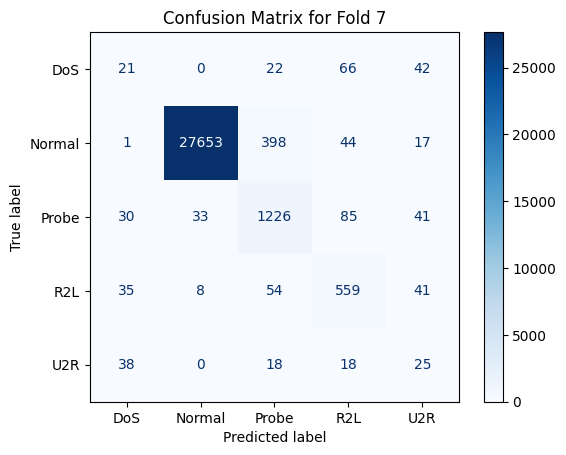


--- Fold 8/10 ---
              precision    recall  f1-score       support
DoS            0.244094  0.205298  0.223022    151.000000
Normal         0.998846  0.985452  0.992104  28113.000000
Probe          0.741993  0.884099  0.806837   1415.000000
R2L            0.719160  0.786227  0.751199    697.000000
U2R            0.195122  0.323232  0.243346     99.000000
accuracy       0.970172  0.970172  0.970172      0.970172
macro avg      0.579843  0.636862  0.603301  30475.000000
weighted avg   0.974173  0.970172  0.971749  30475.000000


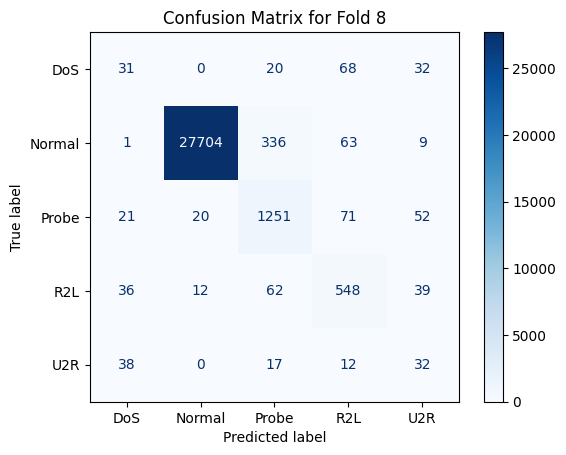


--- Fold 9/10 ---
              precision    recall  f1-score      support
DoS            0.208333  0.166667  0.185185    150.00000
Normal         0.998449  0.984775  0.991565  28112.00000
Probe          0.721108  0.864922  0.786495   1414.00000
R2L            0.720000  0.799427  0.757637    698.00000
U2R            0.205128  0.320000  0.250000    100.00000
accuracy       0.968760  0.968760  0.968760      0.96876
macro avg      0.570604  0.627158  0.594177  30474.00000
weighted avg   0.972710  0.968760  0.970289  30474.00000


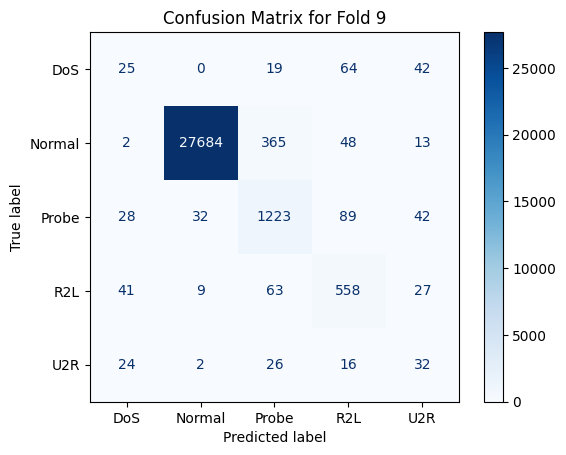


--- Fold 10/10 ---
              precision    recall  f1-score       support
DoS            0.184874  0.146667  0.163569    150.000000
Normal         0.998989  0.984064  0.991470  28112.000000
Probe          0.717003  0.879152  0.789841   1415.000000
R2L            0.736702  0.794835  0.764665    697.000000
U2R            0.210227  0.370000  0.268116    100.000000
accuracy       0.968727  0.968727  0.968727      0.968727
macro avg      0.569559  0.634943  0.595532  30474.000000
weighted avg   0.973301  0.968727  0.970472  30474.000000


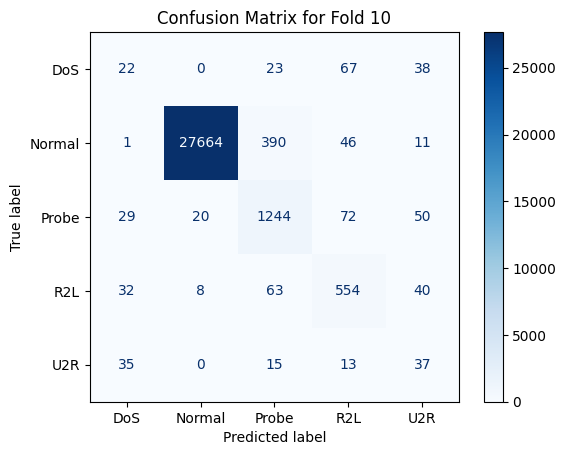

In [103]:
for fold, (train_idx, test_idx) in enumerate(skf.split(train_x_raw, train_Y)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    X_train_raw, X_test_raw = train_x.iloc[train_idx], train_x.iloc[test_idx]
    y_train, y_test = train_Y.iloc[train_idx], train_Y.iloc[test_idx]
    
    # Undersample only the training set
    sampling_strategy = {"Normal": 100000}
    under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_under, y_train_under = under_sampler.fit_resample(X_train_raw, y_train)
    
    # SMOTE the other parts
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)
    
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = rf_model.predict(X_test_raw)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    fold_results.append({
        'Fold': fold + 1,
        'Accuracy': acc,
        'Precision (weighted)': report['weighted avg']['precision'],
        'Recall (weighted)': report['weighted avg']['recall'],
        'F1-Score (weighted)': report['weighted avg']['f1-score'],
        'Confusion Matrix': cm
    })

    print(pd.DataFrame(report).T)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()